In [43]:
import time
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.neighbors import NearestNeighbors

import math


#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

## 2.Récupération et analyse du jeu de données

In [44]:
doc=pd.read_csv('jena_climate_2009_2016.csv')
print(doc)

                  Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
0       01.01.2009 00:00:00    996.50     -8.00    264.76        -8.92   
1       01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90   
2       01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28   
3       01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31   
4       01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07   
...                     ...       ...       ...       ...          ...   
420547  31.12.2016 23:20:00   1000.07     -4.05    269.10        -8.13   
420548  31.12.2016 23:30:00    999.93     -3.35    269.81        -8.06   
420549  31.12.2016 23:40:00    999.82     -3.16    270.01        -8.21   
420550  31.12.2016 23:50:00    999.81     -4.23    268.94        -8.53   
420551  01.01.2017 00:00:00    999.82     -4.82    268.36        -8.42   

        rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
0        93.30          3.33          3.

In [45]:
print(doc.info())
print(doc.shape)
print(doc.head())
print(doc.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420552 entries, 0 to 420551
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420552 non-null  object 
 1   p (mbar)         420552 non-null  float64
 2   T (degC)         420552 non-null  float64
 3   Tpot (K)         420552 non-null  float64
 4   Tdew (degC)      420552 non-null  float64
 5   rh (%)           420552 non-null  float64
 6   VPmax (mbar)     420552 non-null  float64
 7   VPact (mbar)     420552 non-null  float64
 8   VPdef (mbar)     420552 non-null  float64
 9   sh (g/kg)        420552 non-null  float64
 10  H2OC (mmol/mol)  420552 non-null  float64
 11  rho (g/m**3)     420552 non-null  float64
 12  wv (m/s)         420552 non-null  float64
 13  max. wv (m/s)    420552 non-null  float64
 14  wd (deg)         420552 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB
None
(420552, 15)
             Date 

## 3.Préparation et transformation du jeu de données

In [46]:
doc['Date Time'] = pd.to_datetime(doc['Date Time'], format="%d.%m.%Y %H:%M:%S")

In [47]:
doc.set_index("Date Time", inplace=True)

In [48]:
print(doc.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420552 entries, 2009-01-01 00:00:00 to 2017-01-01 00:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420552 non-null  float64
 1   T (degC)         420552 non-null  float64
 2   Tpot (K)         420552 non-null  float64
 3   Tdew (degC)      420552 non-null  float64
 4   rh (%)           420552 non-null  float64
 5   VPmax (mbar)     420552 non-null  float64
 6   VPact (mbar)     420552 non-null  float64
 7   VPdef (mbar)     420552 non-null  float64
 8   sh (g/kg)        420552 non-null  float64
 9   H2OC (mmol/mol)  420552 non-null  float64
 10  rho (g/m**3)     420552 non-null  float64
 11  wv (m/s)         420552 non-null  float64
 12  max. wv (m/s)    420552 non-null  float64
 13  wd (deg)         420552 non-null  float64
dtypes: float64(14)
memory usage: 48.1 MB
None


In [49]:
print(doc)

                     p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
2009-01-01 00:00:00    996.50     -8.00    264.76        -8.92   93.30   
2009-01-01 00:10:00    996.52     -8.02    265.40        -8.90   93.30   
2009-01-01 00:20:00    996.57     -8.41    265.01        -9.28   93.40   
2009-01-01 00:30:00    996.53     -8.51    264.91        -9.31   93.90   
2009-01-01 00:40:00    996.51     -8.31    265.12        -9.07   94.20   
...                       ...       ...       ...          ...     ...   
2016-12-31 23:20:00   1000.07     -4.05    269.10        -8.13   73.10   
2016-12-31 23:30:00    999.93     -3.35    269.81        -8.06   69.71   
2016-12-31 23:40:00    999.82     -3.16    270.01        -8.21   67.91   
2016-12-31 23:50:00    999.81     -4.23    268.94        -8.53   71.80   
2017-01-01 00:00:00    999.82     -4.82    268.36        -8.42   75.70   

                     VPmax (mbar)  VP

In [50]:
#Normalisation Min-Max : Nouvelle valeur = (valeur – min) / (max – min)
#Normalisation moyenne : Nouvelle valeur = (valeur – moyenne) / (écart type)

#Min-max : 
doc_normalisé=(doc-doc.min())/(doc.max()-doc.min())
print(doc_normalisé)

#moyenne :
#(doc-doc.mean())/doc.std()
#print(doc)

                     p (mbar)  T (degC)  Tpot (K)  Tdew (degC)    rh (%)  \
Date Time                                                                  
2009-01-01 00:00:00  0.814742  0.248963  0.233125     0.334372  0.923033   
2009-01-01 00:10:00  0.814939  0.248632  0.243662     0.334788  0.923033   
2009-01-01 00:20:00  0.815430  0.242163  0.237241     0.326891  0.924182   
2009-01-01 00:30:00  0.815037  0.240504  0.235594     0.326268  0.929925   
2009-01-01 00:40:00  0.814840  0.243822  0.239052     0.331255  0.933372   
...                       ...       ...       ...          ...       ...   
2016-12-31 23:20:00  0.849828  0.314480  0.304577     0.350790  0.690982   
2016-12-31 23:30:00  0.848452  0.326091  0.316266     0.352244  0.652039   
2016-12-31 23:40:00  0.847371  0.329242  0.319559     0.349127  0.631361   
2016-12-31 23:50:00  0.847273  0.311494  0.301943     0.342477  0.676048   
2017-01-01 00:00:00  0.847371  0.301708  0.292394     0.344763  0.720850   

           

In [51]:
doc_aggrege = doc_normalisé.resample('2H').mean()
doc_aggrege = doc_aggrege.reset_index()
print(doc_aggrege)
print(doc_aggrege.shape)

                Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
0     2009-01-01 00:00:00  0.814980  0.246323  0.240533     0.333247   
1     2009-01-01 02:00:00  0.818337  0.235197  0.229969     0.318198   
2     2009-01-01 04:00:00  0.822940  0.223545  0.217786     0.300966   
3     2009-01-01 06:00:00  0.832629  0.233690  0.226635     0.314647   
4     2009-01-01 08:00:00  0.845430  0.254561  0.245719     0.338927   
...                   ...       ...       ...       ...          ...   
35060 2016-12-31 16:00:00  0.873645  0.404890  0.391272     0.424979   
35061 2016-12-31 18:00:00  0.870106  0.362595  0.349742     0.402224   
35062 2016-12-31 20:00:00  0.861294  0.338890  0.327406     0.374325   
35063 2016-12-31 22:00:00  0.851613  0.321115  0.311011     0.358583   
35064 2017-01-01 00:00:00  0.847371  0.301708  0.292394     0.344763   

         rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
0      0.928968      0.037369      0.083697      0.004437   0.0

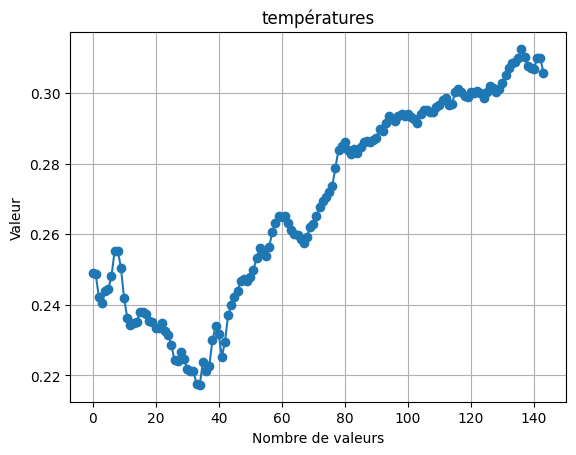

In [52]:
donnees_a_tracer = doc_normalisé['T (degC)'].head(144)

x_values = range(144)

plt.plot(x_values, donnees_a_tracer, marker='o', linestyle='-')
plt.xlabel('Nombre de valeurs')
plt.ylabel('Valeur')
plt.title('températures')
plt.grid(True)

plt.show()

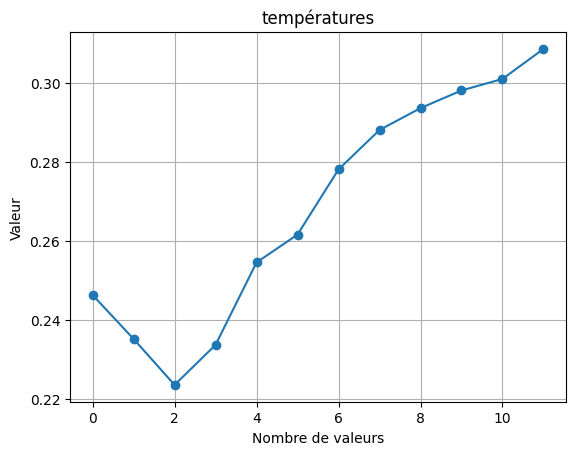

In [53]:
donnees_a_tracer_2 = doc_aggrege['T (degC)'].head(12)

x_values_2 = range(12)

plt.plot(x_values_2, donnees_a_tracer_2, marker='o', linestyle='-')
plt.xlabel('Nombre de valeurs')
plt.ylabel('Valeur')
plt.title('températures')
plt.grid(True)

plt.show()

## 4.Extraction des caractéristiques

In [27]:
def vecteur(df_jour):
    name_col=['p (mbar)','T (degC)','rh (%)','VPact (mbar)','H2OC (mmol/mol)','wv (m/s)']
    vect=[]
    for el in name_col:
        for i in range (12):
            vect.append(df_jour.loc[i,el])
    return vect

In [29]:
nb_jours=2922
matrice_stockee=np.array([vecteur(doc_aggrege.iloc[12*i:12*(i+1)]) for i in range(nb_jours)])

KeyError: 0

In [ ]:
np.save("matrice_vecteurs.csv",matrice_stockee)

## 5.Recherche par similarité

#### 5.1.Méthode exacte

#### 5.2.Méthode approximative

## 6.Exploitation pratique des résultats de recherche